<center><font size = "10"> Week 7 - Connections<center>
<center><font size = "8">Tutorial 02: Connection Probabilities<center>

<font size='3'><font color='blue'> In this tutorial you will learn: 
    
<font size='3'><font color='blue'> how to connect several cells considering the probability of connections between cell types

In [1]:
# Load usefull packages
%matplotlib inline

from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np

## Step1: create the class cell

In [2]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()
        
    def build_morphology(self, filename):
        h.load_file('import3d.hoc')
        h.load_file('stdlib.hoc')
        #morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(self)
    
    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75
        
        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        if hasattr(self, 'apic'):
            for sec in self.apic:
                sec.insert('hh')
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        
        for sec in self.dend:
            sec.insert('hh')
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
                
        for sec in self.axon:
            sec.insert('hh')
            for seg in sec:    
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

## Step2: Instantiate different cells.

<font size='3'>__IMPORTANT:__This cell will show an error. Don't pay attention to it, is not a fatal error and the cells got properly instantiated.
    
<font size='3'>You will be able to run simulations on them.

In [3]:
Pyr1 = Cell('Pyr_01.swc','Pyr1','Pyr')
Pyr2 = Cell('Pyr_02.swc','Pyr2','Pyr')
Int1 = Cell('Int_01.swc','Int1','Int')
cells_Pyr = [Pyr1, Pyr2]
cells_Int = [Int1]
cells = cells_Pyr + cells_Int

error Pyr_01.swc line 12052: could not parse: 
error Pyr_02.swc line 12344: could not parse: 
error Int_01.swc line 11322: could not parse: 


<font size='3'> Print the number of sections per neurite. Realize that the inhibitory cell doesn't have an apical neurite.

In [4]:
for c in cells_Pyr:
    print('%s: %d apical sections, %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.apic),len(c.dend), len(c.soma), len(c.axon)))
for c in cells_Int:
    print('%s: %d basal sections, %d soma sections and %d axon senctions' % (c.name,len(c.dend), len(c.soma), len(c.axon)))

Pyr1: 13 apical sections, 34 basal sections, 2 soma sections and 169 axon senctions
Pyr2: 115 apical sections, 61 basal sections, 2 soma sections and 170 axon senctions
Int1: 21 basal sections, 2 soma sections and 526 axon senctions


## Step 3: Connect based on connection probabilities

In [5]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(source, target, weight = None, delay = 5, source_sec = None, source_neurite = 'axon', target_sec = None, target_neurite = 'dend'):
    rng = np.random.default_rng()
    
    if weight is None:
        weight = rng.uniform() # random weight
    
    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0,len(target_neurite_)) # random dendritic section
    
    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0,len(source_neurite_)) # random axonal section
    
    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn) # store synapse
    
    netcon = h.NetCon(source_neurite_[source_sec](0.5)._ref_v, target_syn, sec=source_neurite_[source_sec])
    netcon.weight[0] = weight
    netcon.delay = delay
    
    print('Connected cells %s -> %s with weight %g and delay %g, from %s[%d] to %s[%d]' % (source.name,target.name,weight,delay,source_neurite,source_sec,target_neurite,target_sec))
    return netcon

In [6]:
# specify connection probabilites between cell types
conn_prob_matrix = np.zeros((2,2))
conn_prob_matrix[0,0] = 0.8 # Pyr to Pyr
conn_prob_matrix[0,1] = 0.2 # Pyr to Int
conn_prob_matrix[1,0] = 0.5 # Int to Pyr
conn_prob_matrix[1,1] = 0.1 # Int to Int

In [7]:
netcons = [] # store all netcons

rng = np.random.default_rng()

# Connect Pyr2 to Pyr1
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr2, Pyr1)
    netcons.append(nc)

# Connect Int1 to Pyr1
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr1, target_neurite='soma')
    netcons.append(nc)

# Connect Pyr1 to Pyr2
if rng.random() < conn_prob_matrix[0,0]:
    nc = connect(Pyr1, Pyr2)
    netcons.append(nc)

# Connect Int1 to Pyr2
if rng.random() < conn_prob_matrix[1,0]:
    nc = connect(Int1, Pyr2, target_neurite='soma')
    netcons.append(nc)

# Connect Pyr1 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr1, Int1)
    netcons.append(nc)

# Connect Pyr2 to Int1
if rng.random() < conn_prob_matrix[0,1]:
    nc = connect(Pyr2, Int1)
    netcons.append(nc)

Connected cells Pyr2 -> Pyr1 with weight 0.463164 and delay 5, from axon[168] to dend[2]
Connected cells Int1 -> Pyr2 with weight 0.426914 and delay 5, from axon[35] to soma[1]
Connected cells Pyr2 -> Int1 with weight 0.973318 and delay 5, from axon[81] to dend[13]


<font size='3'>To test connectivity, let's stimulate one neuron and record another

In [8]:
stim_cell = Pyr2
stim_syn = h.ExpSyn(stim_cell.dend[20](0.5))
stim = h.NetStim() # Make a new stimulator
ncstim = h.NetCon(stim, stim_syn) # Connect stimulator to synapse

<font size='3'>You can play with the parameters below and rerun to see the change in the voltage traces

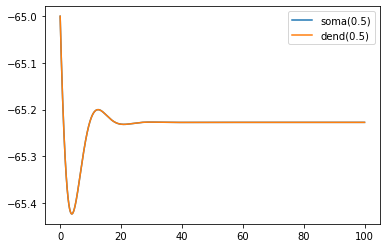

In [9]:
stim.number = 10 # Number of spikes (average)
stim.start = 10 # First spike delay [ms]
ncstim.delay = 1 # NetCon ms
ncstim.weight[0] = 0.8 # NetCon weight

recording_cell = Pyr1

soma_v = h.Vector().record(recording_cell.soma[0](0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend[20](0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-65)
h.continuerun(100)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

## Step 4: Connection probability matrix (between cell types)

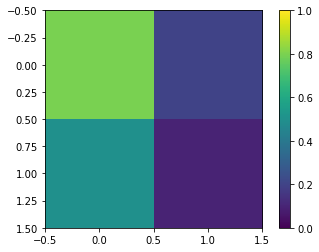

In [10]:
plt.imshow(conn_prob_matrix, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar()